
### <font color='darkblue'>INTRODUCTION </font>

La segmentation sémantique d'image consiste à diviser une image en fragments ou groupes de pixels suivant un certain critère. Autrement dit, la segmentation à pour but d'attribuer une classe à chaque pixel de l'image ou de diviser une image en plusieurs parties/segments ayant des caractéristiques ou des attributs similaires. Ce faisant elle permet de représenter une image de manière significative et facilement analysable et constitue donc une première étape nécessaire à l'analyse des images. Il convient de distinguer la segmantation sémantique de la segmentation d'instance (insatance segmentation) qui elle cherche à attribuer differentes classes à différents exemples d'un même type d'objets.

Les applications de la segmentation d'image sont diverses et variées. Dans le dommaine médical elle peut servire dans l'imagerie médicale pour déterminer la forme des cellules cancéreuses, ce qui est très important car la forme de ces cellules joue un rôle essentiel dans la détermination de la gravité du cancer.
La segmentation sert également dans : 
- La recherche d'image par le contenu : c'est le cas dans recherche par l'exemple où l'on souhaite retrouver des images visuellement similaires à un exemple donné en requête. 
- Systèmes de contrôle automatique du trafic et vidéosurveillance
- Les véhicules autonomes 
- La localisation d'objets sur les images satellites

<img src= https://fr.mathworks.com/solutions/image-video-processing/semantic-segmentation/_jcr_content/mainParsys/band_copy_copy_14735_85071132/mainParsys/columns_1606542234_c_306208022/2/image_copy.adapt.full.high.jpg/1587402465321.jpg style="width:500px;height:300px;"><caption><center> <u> <font color='purple'> Segmentation sématique de la circulation routière</u></center></caption>

Il existe plusieurs techniques pour faire de la segmentation sémantique d'image. L'approche la plus classique de nos consiste à utiliser des réseaux neuronnaux du Deep Learning, dont les architecture sont diverses et variées dans la littérature. Toutefois il est également possible d'utilser les techniques traditionnelles du Machine Learning (telles que les SVM, Méthodes d'ensemble,KNN...) pour faire de la segmentation sémantique, puisqu'il s'agit de classifier. 

L'objectif de ce notebook est de s'intéresser à la segmentation d'images de coupes transversales de cuisses avec les algorithmes de KNN et de Forêt aléatoire.

### <font color='darkblue'>Brève revue de littérature</font>

Dans la documentation sur laquelle s'est appuyée la réalisation de ce travail, les auteurs cherchent d'abord à extraire des variables dans l'image (Feature extraction). Par exemple: 
- Jason Adams Yumou Qiu Yuhang Xu, James C. Schnable (2019) utilisent les intensités des pixels voisins  et celle du pixel lui même pour prédire sa classe.   
- Sreeni (2019) applique différents filtres à l'image afin d'obtenir des variables qui serviront à la classification.
- Xuejun Wang, Shuang Wang, Yubin Zhu, Xiangyi Meng (2012) se basent sur les transformations DCT (local features of image  calculated by Discrete Cosine Transform (DCT)) et les caractéristiques de gris locaux (local gray features) calculées grâce à l'entropy local qui réflecte le degré de discrétion locale d'une image (the local graydiscrete degree of a image) pour constituer les variables explicatives dans leur modèle SVM. Toutes ces méthodes sont limitées par le fait que l'on ne peut pas traiter un grand nombre d'images car le nombre de pixels à contituer pour le training croit rapidement de même que le nombre de variables à utiliser. 
- Cheng Chen, John A. Ozolek, Wei Wang, Gustavo K. Rohde (2011) pour un ensemble de pixels étiquetés prennent les intensités de voisinage de chaque pixel avec une fenêtre de taille prédéfinie centrée sur le pixel donné, ils prennent aussi en compte compris les versions rotatives de chaque fenêtre. Tout cela augmente le nombre de pixels pour l'apprentissage et le nombre de variables : ils réduisent alors le nombre de pixel pour l'apprentissage en appliquant le K-means et réduisent le nombre de variables avec le PCA et le stepwise discriminant analysis (SDA) 

Dans ce notebook nous utilisons la méthodologie des deux premiers exemples cités ci-dessus et nous appliquont le KNN avec 5 voisins et les forêts aléatoires de avec 15 arbres, afin de limiter le temps d'exécution et d'éviter les problèmes de mémoire de l'ordinateur.

In [1]:
import numpy as np
import cv2
import pandas as pd

import pickle
from matplotlib import pyplot as plt
import os
from PIL import Image

import random
from sklearn.preprocessing import OneHotEncoder ; onehotenc = OneHotEncoder()
from sklearn import metrics
from sklearn import neighbors
from sklearn import svm
from sklearn.metrics import jaccard_score
import timeit

In [2]:
chemin_image = "./DATASET_MUSCLES/anatAtlas25/"
chemin_mask = "./DATASET_MUSCLES/allmusclesf/"

input_img_paths = sorted(
    [
        os.path.join(chemin_image, fname)
        for fname in os.listdir(chemin_image)
        if fname.endswith(".jpg")
    ]
)
input_img = sorted(os.listdir(chemin_image))

target_img_paths = sorted(
    [
        os.path.join(chemin_mask, fname)
        for fname in os.listdir(chemin_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
target_img = sorted(os.listdir(chemin_mask))

### <font color='darkblue'> VISUALISATION </font>

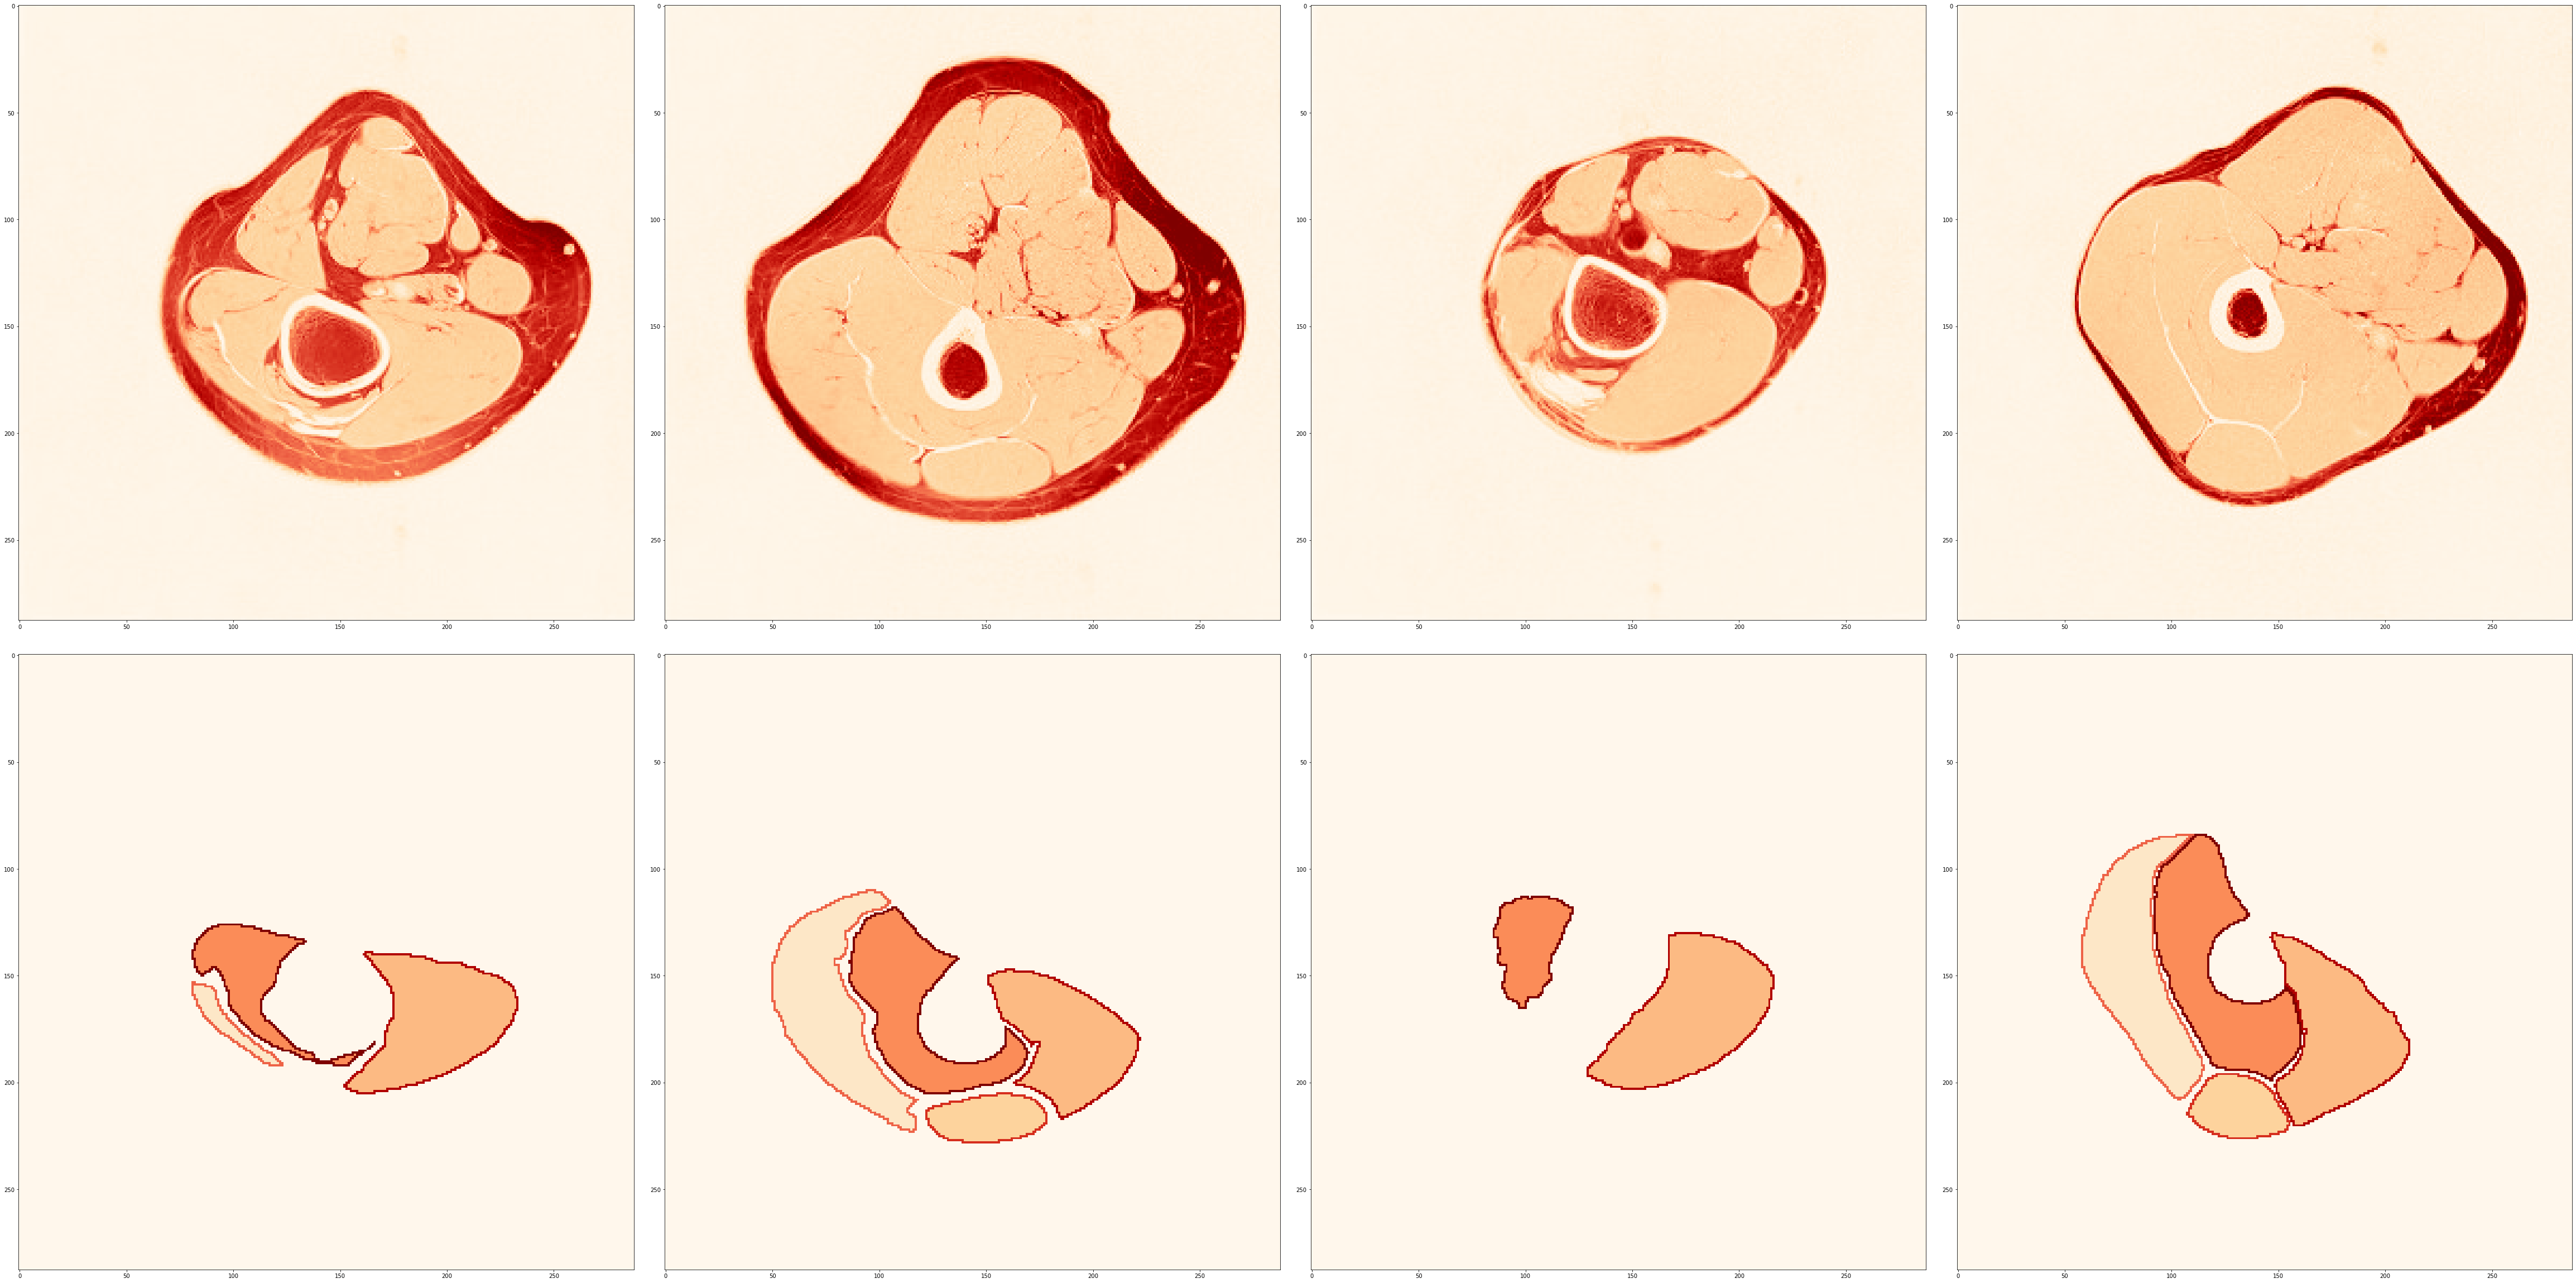

In [3]:
fig, axs = plt.subplots(2, 4, figsize=(64, 32), constrained_layout=True)

FIGURE = [3,10,20,30]
for i in range(4): 
    axs[0,i].imshow(Image.open(input_img_paths[FIGURE[i]]),cmap='OrRd')
    axs[0,i].grid(False)
    axs[1,i].imshow(Image.open(target_img_paths[FIGURE[i]]),cmap='OrRd')
    axs[1,i].grid(False)

In [4]:
##taille des images
dim = np.asarray(Image.open(input_img_paths[3])).shape 

##vérifier le nombre de classes des pixels des masques
##vérifier les différentes classes existantes
w = []
for image in target_img_paths:   
    ima = Image.open(image)
    ima = np.asarray(ima)
    w.append(np.unique(ima).tolist())
w

[[0, 3, 4, 7, 8],
 [0, 3, 4, 7, 8],
 [0, 1, 3, 4, 5, 7, 8],
 [0, 1, 3, 4, 5, 7, 8],
 [0, 1, 3, 4, 5, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 3, 4, 7, 8],
 [0, 3, 4, 7, 8],
 [0, 3, 4, 7, 8],
 [0, 1, 3, 4, 5, 7, 8],
 [0, 1, 3, 4, 5, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2,

In [5]:
w[30] ## on a  toutes les classes. on peut les visualiser ...

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [6]:
print("Taille des images :",dim,"\n","Nombre de classes :",max([max(x) for x in w])+1)

Taille des images : (288, 288) 
 Nombre de classes : 9


In [7]:
parties = np.zeros((288, 288,9))
imag = np.asarray(Image.open(target_img_paths[30]))
for j in range(9):
    parties[:,:,j][np.where(imag ==j)[0], np.where(imag==j)[1]]=j

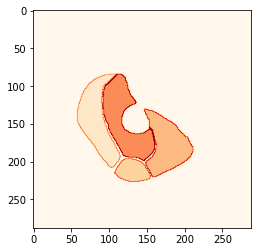

In [8]:
plt.imshow(Image.open(target_img_paths[30]),cmap='OrRd')

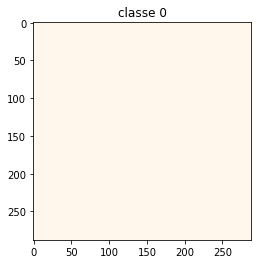

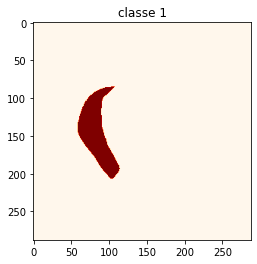

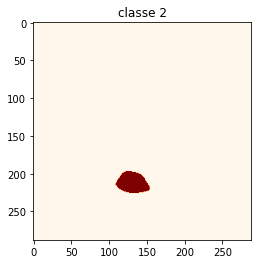

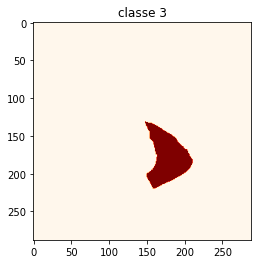

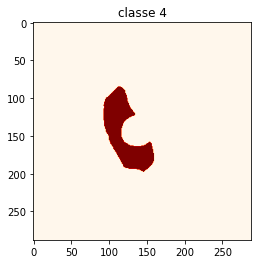

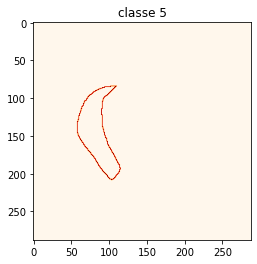

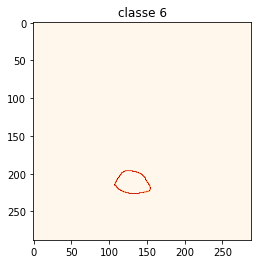

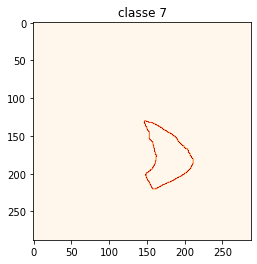

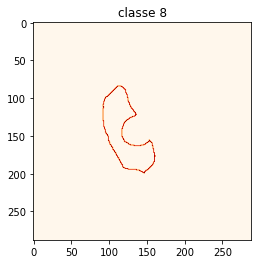

In [9]:
mylist = [parties[:,:,j] for j in range(9)] 
for i in range(len(mylist)):
    plt.imshow(mylist[i],cmap='OrRd')
    plt.title(f"classe {i}")
    plt.show()

### <font color='darkblue'>  I- 1ère approche : on utilise les intensités du pixel et celui de ses 8 voisins pour prédire sa classe </font>

On créer une fonction qui soit en mesure de prendre pour chaque pixel son intensité et celui des voisins, grâce à une fenetre mobile. Mais aux niveaux des borddures, on perd certain pixels , pour éviter cela on fait du padding

In [10]:
def give_neighbour(a, shape,pad = False):  
    if pad == True:
        a = np.pad(a,1)
        ##les trois lignes qui sivront permettent de faire dérouler une "fenêtre mobiles sur l'array 2-D
    s = (a.shape[0] - shape[0] + 1,) + (a.shape[1] - shape[1] + 1,) + shape
    strides = a.strides + a.strides
    h = np.lib.stride_tricks.as_strided(a, shape=s, strides=strides)
    return h.reshape(h.shape[0]*h.shape[1],h.shape[2]*h.shape[3])

**Illustration**

In [11]:
m = np.array([[13, 21, 13,  8],
              [ 5, 10, 22, 14],
              [21, 33,  9,  0],
              [ 0,  0,  0,  0]])
np.pad(m,1)

array([[ 0,  0,  0,  0,  0,  0],
       [ 0, 13, 21, 13,  8,  0],
       [ 0,  5, 10, 22, 14,  0],
       [ 0, 21, 33,  9,  0,  0],
       [ 0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0]])

In [12]:
give_neighbour(m,(3,3),pad = True)

array([[ 0,  0,  0,  0, 13, 21,  0,  5, 10],
       [ 0,  0,  0, 13, 21, 13,  5, 10, 22],
       [ 0,  0,  0, 21, 13,  8, 10, 22, 14],
       [ 0,  0,  0, 13,  8,  0, 22, 14,  0],
       [ 0, 13, 21,  0,  5, 10,  0, 21, 33],
       [13, 21, 13,  5, 10, 22, 21, 33,  9],
       [21, 13,  8, 10, 22, 14, 33,  9,  0],
       [13,  8,  0, 22, 14,  0,  9,  0,  0],
       [ 0,  5, 10,  0, 21, 33,  0,  0,  0],
       [ 5, 10, 22, 21, 33,  9,  0,  0,  0],
       [10, 22, 14, 33,  9,  0,  0,  0,  0],
       [22, 14,  0,  9,  0,  0,  0,  0,  0],
       [ 0, 21, 33,  0,  0,  0,  0,  0,  0],
       [21, 33,  9,  0,  0,  0,  0,  0,  0],
       [33,  9,  0,  0,  0,  0,  0,  0,  0],
       [ 9,  0,  0,  0,  0,  0,  0,  0,  0]])

**Constitution de l'échantillon d'apprentissage:** L'ensemble de données à notre disposition contient 500 images. A la base notre objetif est de faire de la segmentation sémantique en classant chaque pixel d'une image dans une classe donnée. Or quelques exemples d'images peuvent générer plusieurs millions de pixels pour l'entraînement. Nous nous trouvons donc limiter par la taille élevée que pourrait prendre nos données. Nous prenons un échantillon aléatoire de 35 images, pour constituer notre échantillon d'apprentissage.

In [13]:
random.seed(3)
train_input_img_paths = random.sample(input_img_paths,35)
random.seed(3)
train_target_img_paths = random.sample(target_img_paths,35)

In [14]:
def feature_x(list_image_paths, shape = (3,3),pad = True): ## cette fonction appliquer la fonction give_neighbour
                                                           ## a une liste d'image et empilras les matrices
    X_list = []
    for image in list_image_paths:
        ima = Image.open(image)
        ima = np.asarray(ima)
        ima = give_neighbour(ima, shape,pad = pad)/255.0
        X_list.append(ima)

    return np.concatenate(X_list)

In [15]:
X_train = feature_x(train_input_img_paths); X_train.shape ## (288*288*35, 3*3)

(2903040, 9)

In [16]:
def process_y(list_mask_paths): ## pour applattir la matrice des masques
    y_list = []
    for mask in list_mask_paths:
        o_imag = Image.open(mask)
        o_imag = np.asarray(o_imag)
        y_list.append( o_imag.flatten() )
    return np.concatenate(y_list)   

In [17]:
Y_train = process_y(train_target_img_paths); Y_train.shape ## (288*288*35, )

(2903040,)

In [18]:
one_hot_Y_train = onehotenc.fit_transform(Y_train.flatten().reshape(-1,1)).toarray() 

###  <font color='darkblue'> a- KNN </font>

In [19]:
knn = neighbors.KNeighborsClassifier()
start = timeit.default_timer() # start timer
knn.fit(X_train, Y_train) ##normallement vu que que c'est une classification , on doit utiliser le one-hot-enc. On a utilisé directement y afin de faire des comparaisons, toute fois on a utilisé aussi le one-hot , et 'est la même chose cela donne
stop = timeit.default_timer() # stop timer
print('Time: {:.5f} '.format(stop - start)) ## temps en seconde

Time: 3722.12766 


Je receuille dans test_input_img_paths et test_target_img_paths les chemins des images et des masques qui peuvent servir au test, ceux-ci ne faisant pas partir de l'échantillon d'apprentissage 

In [20]:
test_input_img_paths = [image for image in filter (lambda x: x not in train_input_img_paths, input_img_paths)] 

test_target_img_paths = [image for image in filter (lambda x: x not in train_target_img_paths, target_img_paths)] 

Nous prenons par exemple les 4ème et 51ème éléments de la liste test_input_img_paths pour faires les tests. Je les choisis au hasard, mais en plus je voudrais prendre une image  où il y a toutes les classes (test_input_img_paths[50]) et une autres où il n'y aura pas toute les classes (test_input_img_paths[3]) 

In [21]:
x_test1 = feature_x([test_input_img_paths[3]])
pred_knn1 = knn.predict(x_test1).reshape((288,288))

In [22]:
x_test2 = feature_x([test_input_img_paths[50]])
pred_knn2 = knn.predict(x_test2).reshape((288,288))

Vu que les pixels relatifs au background (y=0) sont majoritaires, on aimerait aussi entrainer sur un échatillon où il n'y pas de ces types de pixels

In [23]:
df = pd.DataFrame(np.c_[X_train,Y_train])
df = df.rename(columns={9: 'y_train'})
new_df = df[df['y_train']!=0]

In [24]:
len(new_df)

331251

In [25]:
knn_prim = neighbors.KNeighborsClassifier()
start = timeit.default_timer() # start timer
knn_prim.fit(new_df.drop(["y_train"],axis=1), new_df["y_train"])
stop = timeit.default_timer() # stop timer
print('Time: {:.5f} s'.format(stop - start))

Time: 4.52530 s


In [26]:
pred_knn1_prim = knn_prim.predict(x_test1).reshape((288,288))
pred_knn2_prim = knn_prim.predict(x_test2).reshape((288,288))

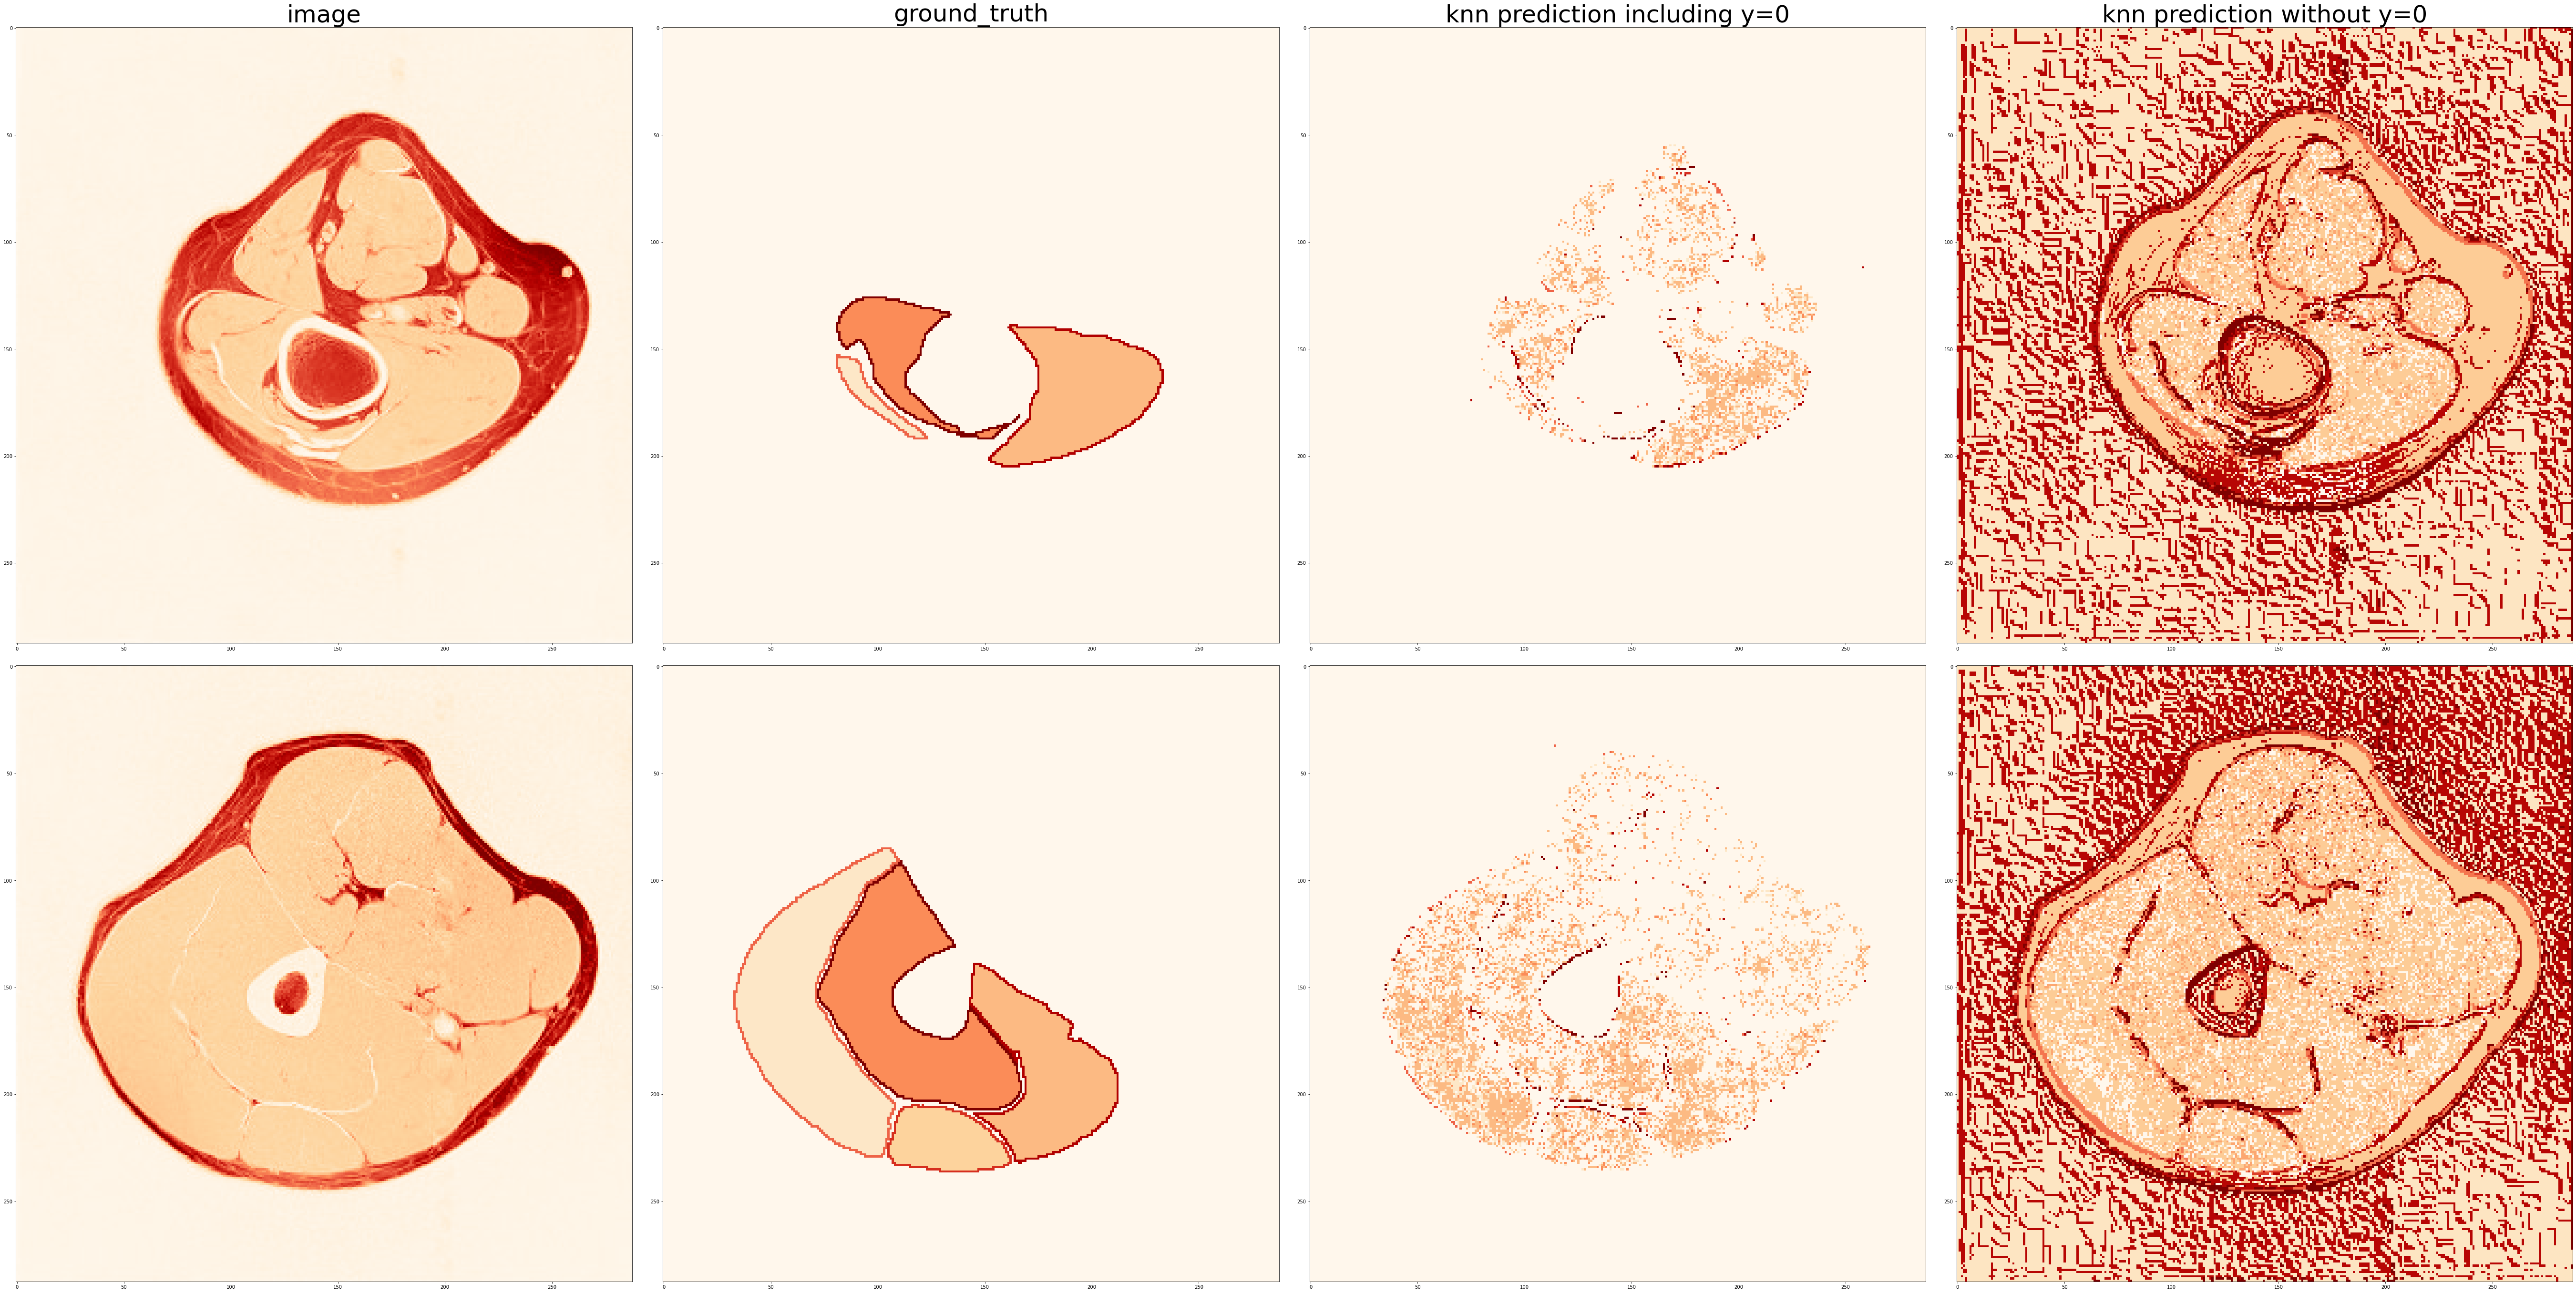

In [27]:
fig, axs = plt.subplots(2, 4, figsize=(75, 37.5), constrained_layout=True)
FIGURE1 = [Image.open(test_input_img_paths[3]),Image.open(test_target_img_paths[3]),pred_knn1,pred_knn1_prim]
FIGURE2 = [Image.open(test_input_img_paths[50]), Image.open(test_target_img_paths[50]),pred_knn2,pred_knn2_prim] 
title = ["image","ground_truth","knn prediction including y=0","knn prediction without y=0"]

for i in range(4):
    axs[0,i].imshow(FIGURE1[i],cmap='OrRd')
    axs[0,i].grid(False)
    axs[0,i].set_title(title[i],fontsize = 50)
    axs[1,i].imshow(FIGURE2[i],cmap='OrRd')
    axs[1,i].grid(False)  

En gardant les numéros de classes sous forme quantitative, et en supprimant les pixels où y =0 (background), on reconstitue même l'image test presque au complet à partir du modèle. Ce qui m'a surpris et c'est pourquoi j'ai gardé ce résultat

**Essais de calcul de l'IoU**

In [29]:
def data_for_jaccard(y_true,y_pred): ## y_true liste oontenant le chemin du masque
    y_true = process_y(y_true)
    y_true = onehotenc.transform(y_true.flatten().reshape(-1,1)).toarray() 
    y_pred = onehotenc.transform(y_pred.flatten().reshape(-1,1)).toarray() 
    return y_true,y_pred

Je calcule l'indice de jaccard pour chaque masque (avec la prediction où y = 0 est inclut)

'macro':

    Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
'weighted':

    Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance.


In [30]:
## INDICE DE JACCARD POUR LA PREMIERE IMAGE 
v1,v2 = data_for_jaccard([test_target_img_paths[3]], pred_knn1)
jaccard_score(v1,v2 ,average='weighted')

0.8900125570276874

In [31]:
jaccard_score(v1,v2 ,average='macro')

0.14938551463960156

In [32]:
## INDICE DE JACCARD POUR LA SECONDE IMAGE
v1,v2 = data_for_jaccard([test_target_img_paths[50]], pred_knn2)
jaccard_score(v1,v2 ,average='weighted')

0.7205327953045871

In [33]:
jaccard_score(v1,v2 ,average='macro')

0.1675530807281926

In [34]:
##autre méthode trouvée, mais ça ne marche, quand j'ai essayé
from keras import backend as K 
def iou_coef(y_true, y_pred, smooth=1):
    
    """Both y_true and y_pred are m x r x c x n where m is the number of images, r is the number of rows,
    c is the number of columns, and n is the number of classes."""
    
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def data_for_iou(y_list,nb_classes): ##tranformé la liste de matrice (288,288) en matrice (len(y_list),288,288,nb_classes)
#y_list liste de matrices (288,288)

    mat = np.zeros((len(y_list),288,288,nb_classes))
    for i in range(len(y_list)):
        for j in range(nb_classes):
            mat[i,:,:,j][np.where(y_list[i] == j)[0], np.where(y_list[i]==j)[1]]=1
    return mat

### <font color='darkblue'> b- Random forest</font>

In [35]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators =15)
start = timeit.default_timer() # start timer
rfc.fit(X_train, one_hot_Y_train)
stop = timeit.default_timer() # stop timer
print('Time: {:.5f} '.format(stop - start)) ## temps en seconde

Time: 521.86399 


In [36]:
pred_rfc1 = np.argmax(rfc.predict(x_test1),axis = 1).reshape((288,288))
pred_rfc2 = np.argmax(rfc.predict(x_test2),axis = 1).reshape((288,288))

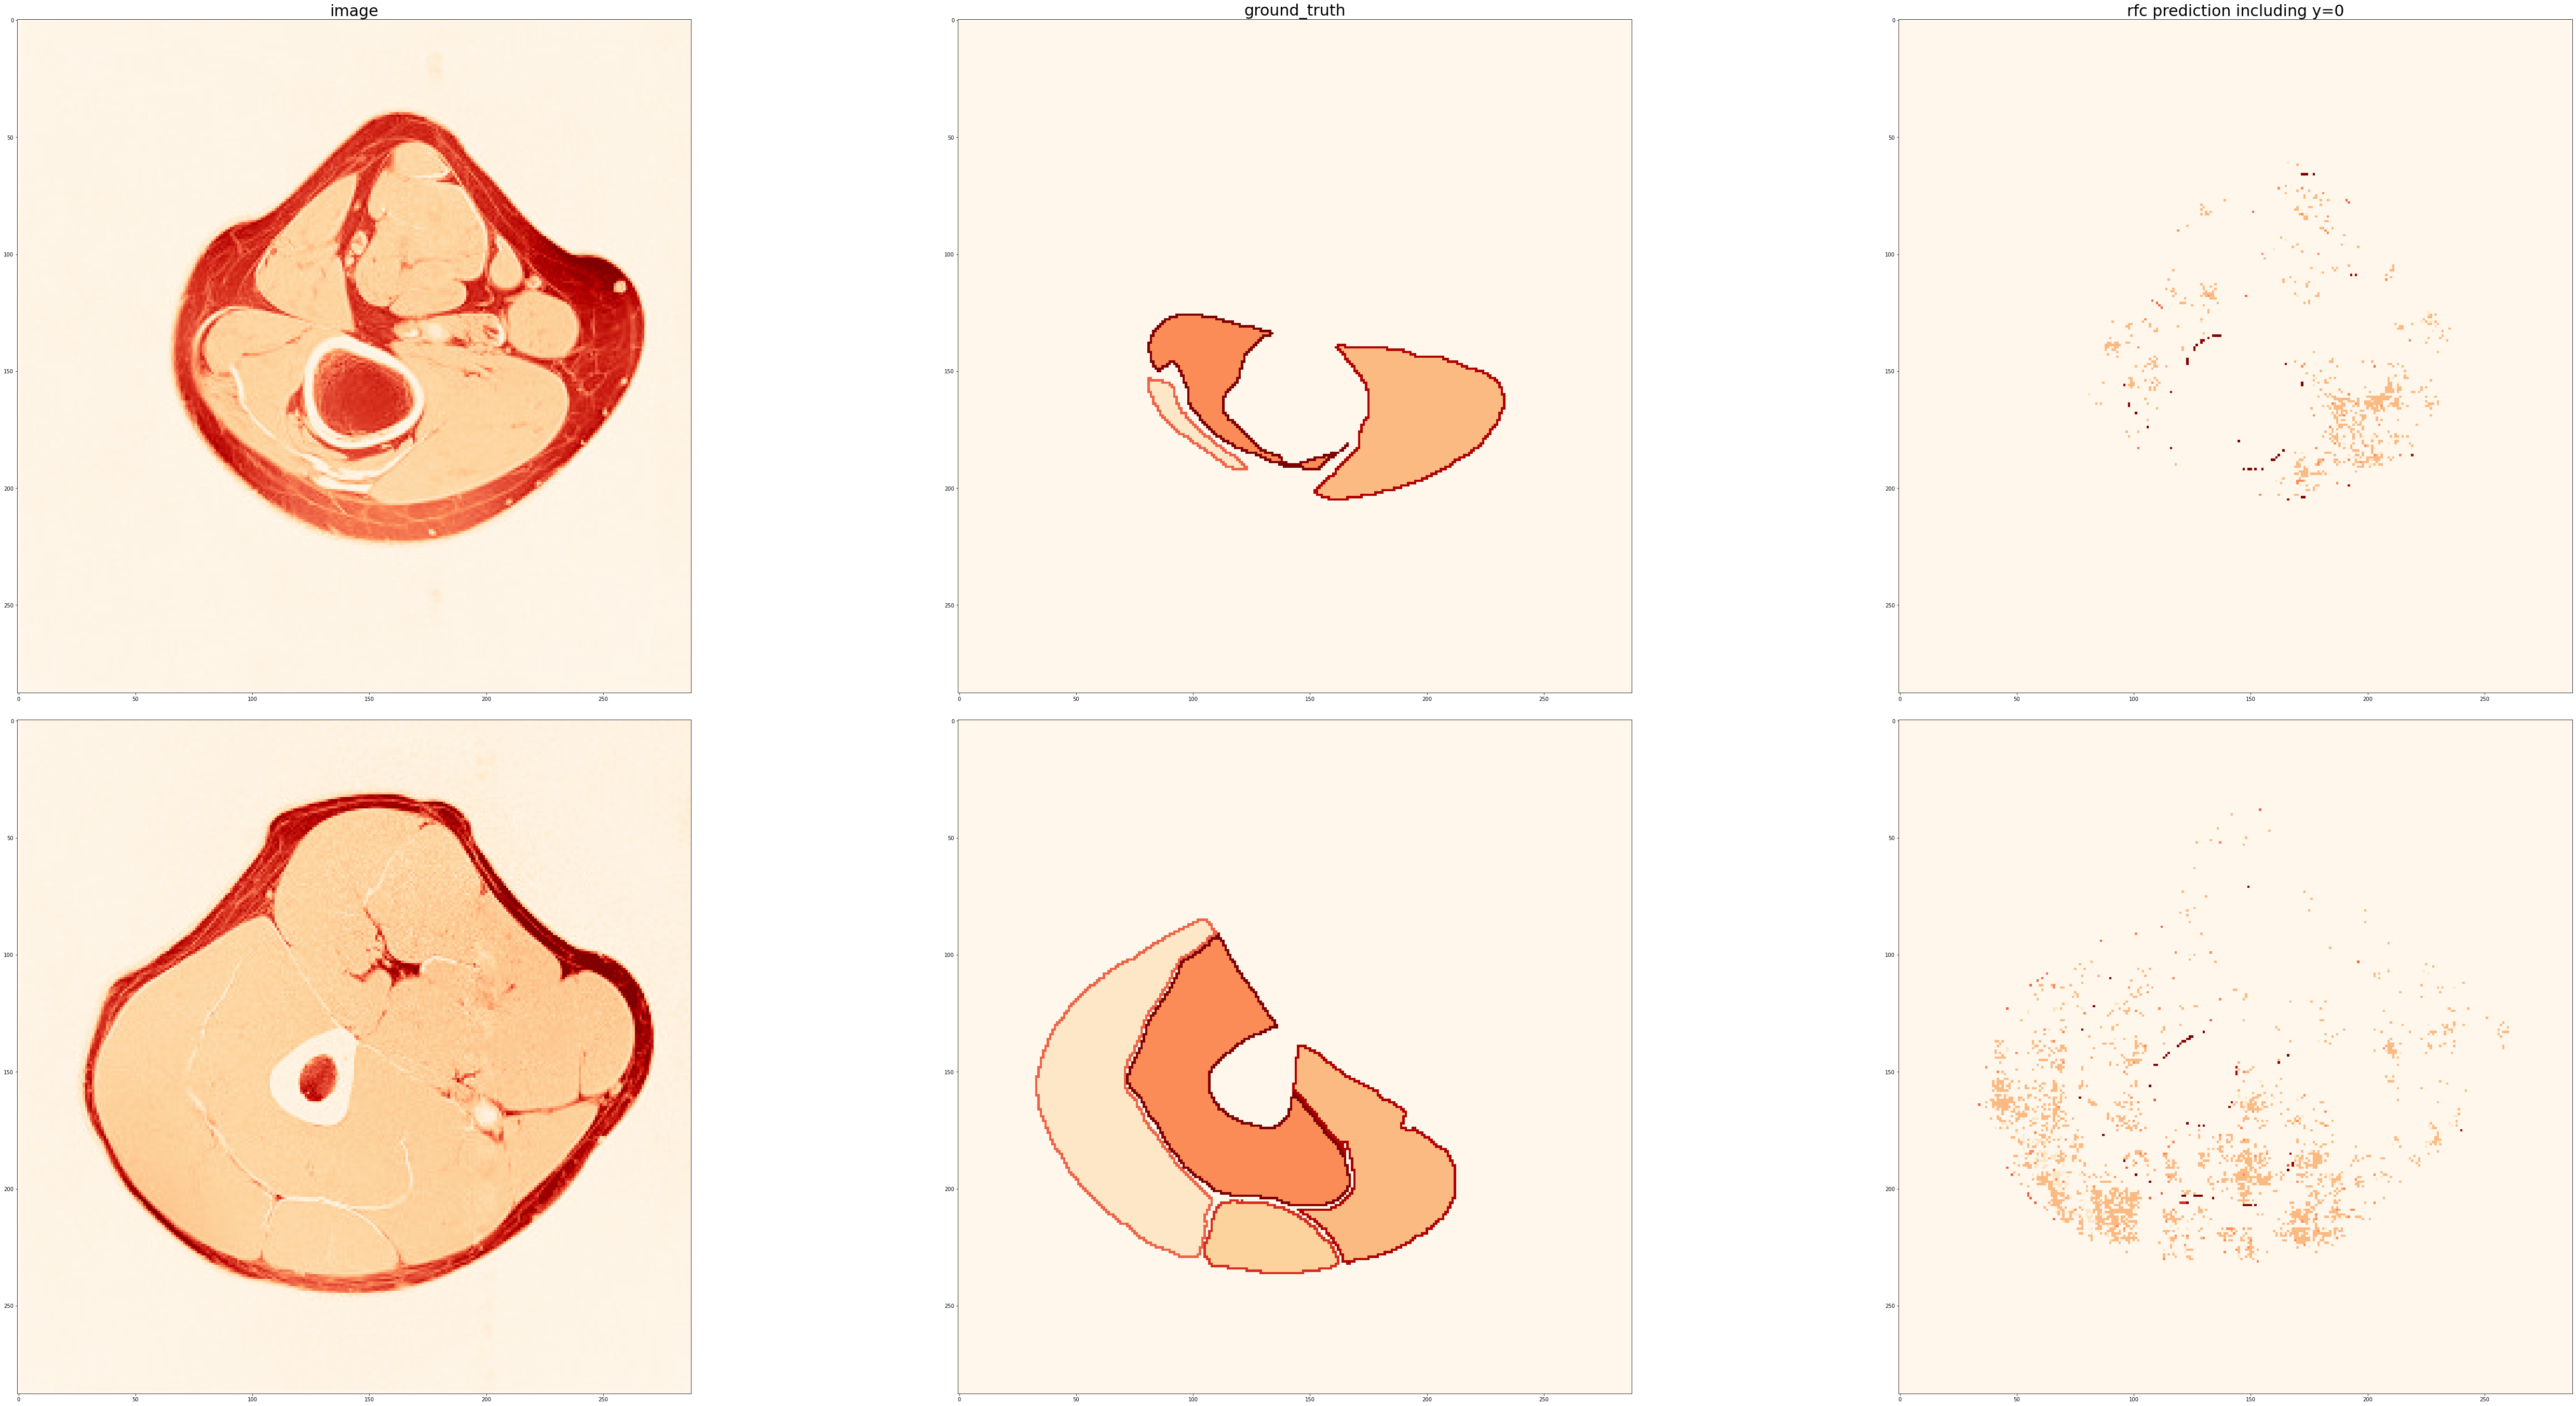

In [37]:
fig, axs = plt.subplots(2, 3, figsize=(75, 37.5), constrained_layout=True)
FIGURE1 = [Image.open(test_input_img_paths[3]),Image.open(test_target_img_paths[3]),pred_rfc1]
FIGURE2 = [Image.open(test_input_img_paths[50]), Image.open(test_target_img_paths[50]),pred_rfc2] 
title = ["image","ground_truth","rfc prediction including y=0"]

for i in range(3):
    axs[0,i].imshow(FIGURE1[i],cmap='OrRd')
    axs[0,i].grid(False)
    axs[0,i].set_title(title[i],fontsize = 30)
    axs[1,i].imshow(FIGURE2[i],cmap='OrRd')
    axs[1,i].grid(False)  

In [38]:
## INDICE DE JACCARD POUR LA PREMIERE IMAGE 
v1,v2 = data_for_jaccard([test_target_img_paths[3]], pred_rfc1)
jaccard_score(v1,v2 ,average='macro')

C:\Users\jeane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.12154164611438786

In [39]:
## INDICE DE JACCARD POUR LA seconde IMAGE 
v1,v2 = data_for_jaccard([test_target_img_paths[50]], pred_rfc2)
jaccard_score(v1,v2 ,average='macro')

0.11853396171495051

Conclusion

### <font color='darkblue'> II- Seconde approche : on fait du feature extraction , en appliquant plusieurs filtres à l'image</font>

In [40]:
from skimage.filters import roberts, sobel, scharr, prewitt

**Filtre de Gabor**

En   traitement   d'images, la fonction de Gabor  peut s'écrire de la manirère suivante: de la manière suivante : 

<img src="gabor 2.jpg" style="width:450px;height:200px;">


L'application de cette fonction à un masque de convolution, définit un filtre de convolution qu'on appelons filtre de Gabor. C'est un filtre linéaire dont la réponse impulsionnelle est une sinusoïde modulée par une fonction gaussienne.Le fonctionnement est proche des traitements visuels humains, ontl'avantage d'être paramétrables en fréquence, et en orientation (ARNAUD CALMETTES, GUILLAUME CEDILLE (?))

<img src="gabor 1.jpg" style="width:500px;height:350px;"> 
<caption><center> <u> <font color='purple'> Convolution d'une image par un banc de filtres de Gabor</u></center></caption>

**Filtre de Sobel :**
Le filtre de Sobel est un opérateur utilisé en traitement d'image pour la détection de contours. l'opérateur calcule le gradient de l'intensité de chaque pixel. Ceci indique la direction de la plus forte variation du clair au sombre, ainsi que le taux de changement dans cette direction. On connaît alors les points de changement soudain de luminosité, correspondant probablement à des bords, ainsi que l'orientation de ces bords. ( <a href="https://fr.wikipedia.org/wiki/Filtre_de_Sobel">Wikipédia</a>)

<img src="sobel 2.jpg" style="width:400px;height:250px;"> 


In [41]:
##https://github.com/bnsreenu/python_for_microscopists/blob/master/67b_Feature_based_segm_RF_multi_image_PREDICT.py

def feature_extraction(img_path):
    x_dataset = pd.DataFrame()
    for image in img_path:  #iterate through each file 
    
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.

        img = Image.open(image)  #Read images
        img = np.asarray(img)
################################################################
#START ADDING DATA TO THE DATAFRAME

        #Add pixel values to the data frame
        pixel_values = img.reshape(-1)
        df['Pixel_Value'] = pixel_values   #Pixel value itself as a feature


############################################################################    
#Generate Gabor features

        num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
        kernels = []
        for theta in range(2):   #Define number of thetas
            theta = theta / 4. * np.pi
            for sigma in (1, 3):  #Sigma with 1 and 3
                for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
                    for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5


                        gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
        #                print(gabor_label)
                        ksize=9
                        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                        kernels.append(kernel)
                        #Now filter the image and add values to a new column 
                        fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                        filtered_img = fimg.reshape(-1)
                        df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                        print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                        num += 1  #Increment for gabor column label


########################################
#Gerate OTHER FEATURES and add them to the data frame

        #CANNY EDGE
        edges = cv2.Canny(img, 100,200)   #Image, min and max values
        edges1 = edges.reshape(-1)
        df['Canny_Edge'] = edges1 #Add column to original dataframe

        #ROBERTS EDGE
        edge_roberts = roberts(img)
        edge_roberts1 = edge_roberts.reshape(-1)
        df['Roberts'] = edge_roberts1

        #SOBEL
        edge_sobel = sobel(img)
        edge_sobel1 = edge_sobel.reshape(-1)
        df['Sobel'] = edge_sobel1

        #SCHARR
        edge_scharr = scharr(img)
        edge_scharr1 = edge_scharr.reshape(-1)
        df['Scharr'] = edge_scharr1

        #PREWITT
        edge_prewitt = prewitt(img)
        edge_prewitt1 = edge_prewitt.reshape(-1)
        df['Prewitt'] = edge_prewitt1

        #GAUSSIAN with sigma=3
        from scipy import ndimage as nd
        gaussian_img = nd.gaussian_filter(img, sigma=3)
        gaussian_img1 = gaussian_img.reshape(-1)
        df['Gaussian s3'] = gaussian_img1

        #GAUSSIAN with sigma=7
        gaussian_img2 = nd.gaussian_filter(img, sigma=7)
        gaussian_img3 = gaussian_img2.reshape(-1)
        df['Gaussian s7'] = gaussian_img3

        #MEDIAN with sigma=3
        median_img = nd.median_filter(img, size=3)
        median_img1 = median_img.reshape(-1)
        df['Median s3'] = median_img1

        #VARIANCE with size=3
        variance_img = nd.generic_filter(img, np.var, size=3)
        variance_img1 = variance_img.reshape(-1)
        df['Variance s3'] = variance_img1  #Add column to original dataframe


    ######################################                    
    #Update dataframe for images to include details for each image in the loop
        x_dataset = x_dataset.append(df)
    return x_dataset 

In [42]:
X_train_2 = feature_extraction(train_input_img_paths); X_train_2.shape

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

Gabor31 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.05
Gabor32 : theta= 0.7853981633974483 : sigma= 3 : lamda= 2.356194490192345 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : thet

(2903040, 42)

In [43]:
Y_train_2 = process_y(train_target_img_paths); Y_train_2.shape ## (288*288*35, )

(2903040,)

### <font color='darkblue'> a- KNN</font>

In [44]:
knn_2nd = neighbors.KNeighborsClassifier()
start = timeit.default_timer() # start timer
knn_2nd.fit(X_train_2,one_hot_Y_train )
stop = timeit.default_timer() # stop timer
print('Time: {:.5f} s'.format(stop - start))

Time: 7875.04582 s


In [45]:
x_test1_prim = feature_extraction([test_input_img_paths[3]])
x_test2_prim = feature_extraction([test_input_img_paths[50]])

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

In [46]:
start = timeit.default_timer() # start timer
pred_knn_2nd1 = np.argmax(knn_2nd.predict(x_test1_prim),axis= 1).reshape((288,288))
pred_knn_2nd2 = np.argmax(knn_2nd.predict(x_test2_prim),axis =1).reshape((288,288))
stop = timeit.default_timer() # stop timer
print('Time: {:.5f} s'.format(stop - start))

Time: 1656.21573 s


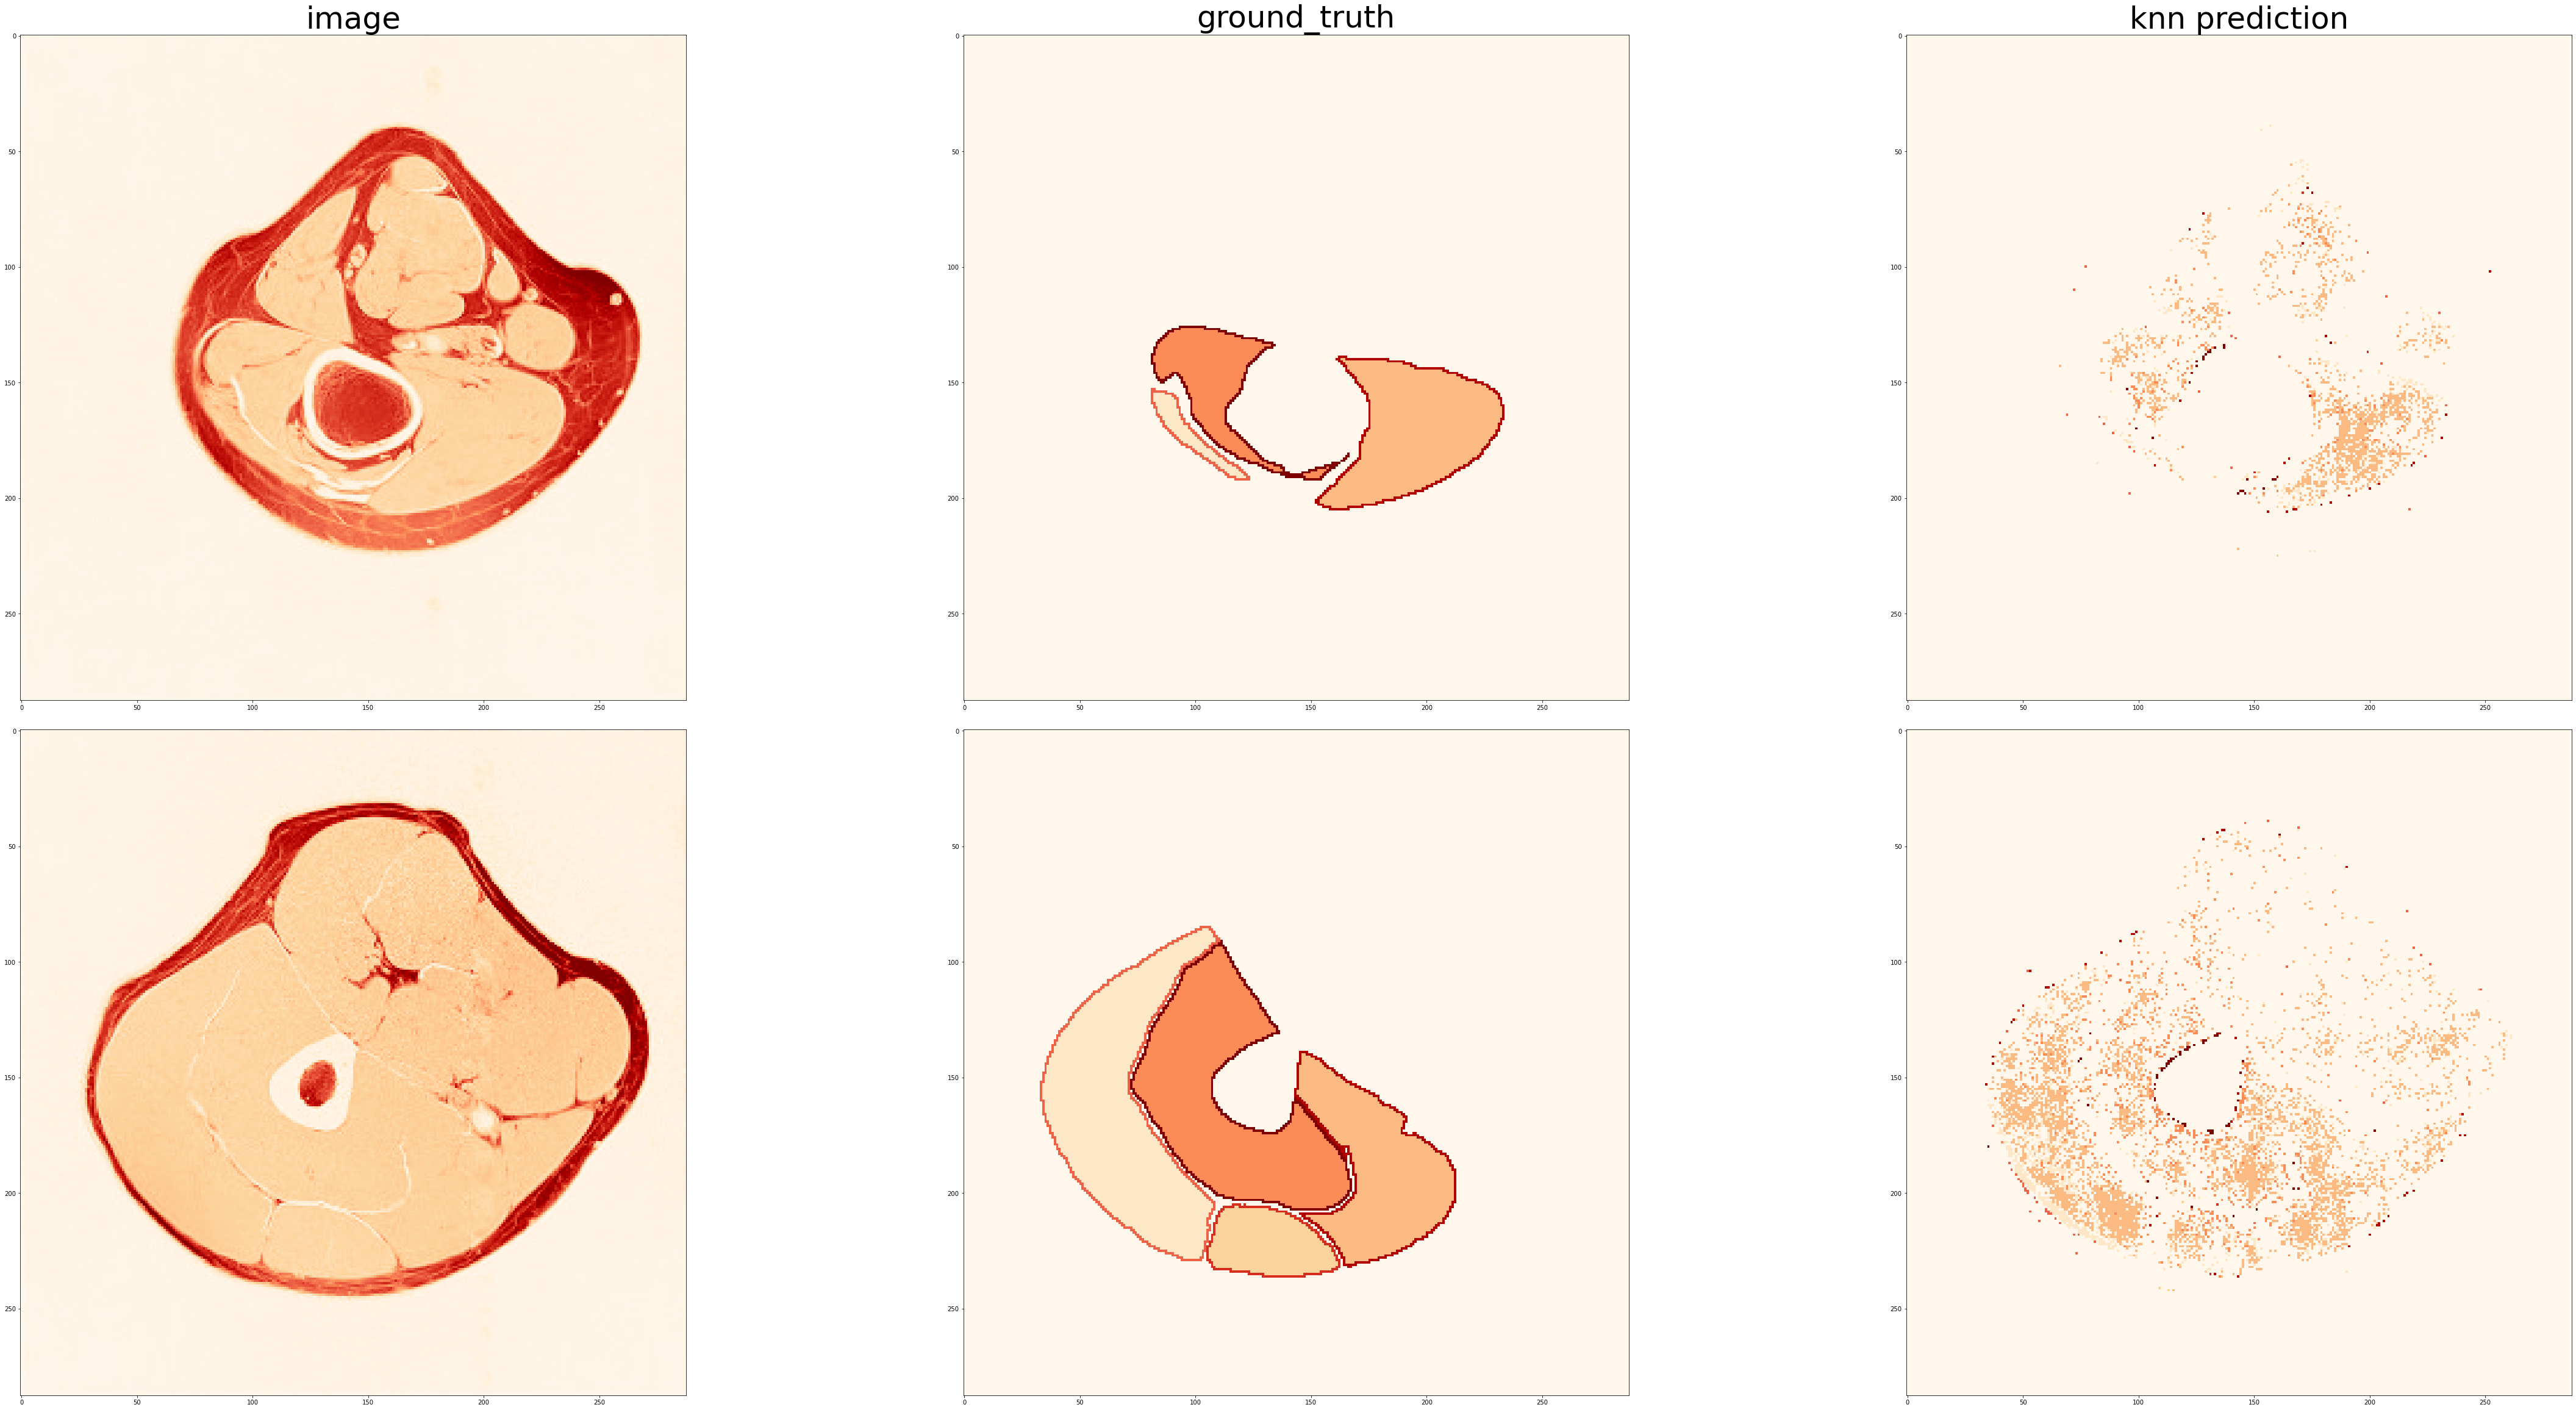

In [47]:
fig, axs = plt.subplots(2, 3, figsize=(64, 32), constrained_layout=True)
FIGURE1 = [Image.open(test_input_img_paths[3]),Image.open(test_target_img_paths[3]),pred_knn_2nd1]
FIGURE2 = [Image.open(test_input_img_paths[50]), Image.open(test_target_img_paths[50]),pred_knn_2nd2] 
title = ["image","ground_truth","knn prediction"]

for i in range(3):
    axs[0,i].imshow(FIGURE1[i],cmap='OrRd')
    axs[0,i].grid(False)
    axs[0,i].set_title(title[i],fontsize = 50)
    axs[1,i].imshow(FIGURE2[i],cmap='OrRd')
    axs[1,i].grid(False)  

In [48]:
## INDICE DE JACCARD POUR LA premire IMAGE
v1,v2 = data_for_jaccard([test_target_img_paths[3]], pred_knn_2nd1)
jaccard_score(v1,v2 ,average='macro')

0.14176932946323542

In [49]:
## INDICE DE JACCARD POUR LA seconde IMAGE
v1,v2 = data_for_jaccard([test_target_img_paths[50]], pred_knn_2nd2)
jaccard_score(v1,v2 ,average='macro')

0.14014650677486412

### <font color='darkblue'> b- Random forest </font>

In [50]:
rfc_2nd = neighbors.KNeighborsClassifier()
start = timeit.default_timer() # start timer
rfc_2nd.fit(X_train_2,one_hot_Y_train )
stop = timeit.default_timer() # stop timer
print('Time: {:.5f} s'.format(stop - start))

Time: 4355.98764 s


In [51]:
start = timeit.default_timer() # start timer
pred_rfc_2nd1 = np.argmax(rfc_2nd.predict(x_test1_prim),axis= 1).reshape((288,288))
pred_rfc_2nd2 = np.argmax(rfc_2nd.predict(x_test2_prim),axis =1).reshape((288,288))
stop = timeit.default_timer() # stop timer
print('Time: {:.5f} s'.format(stop - start))

Time: 1557.61552 s


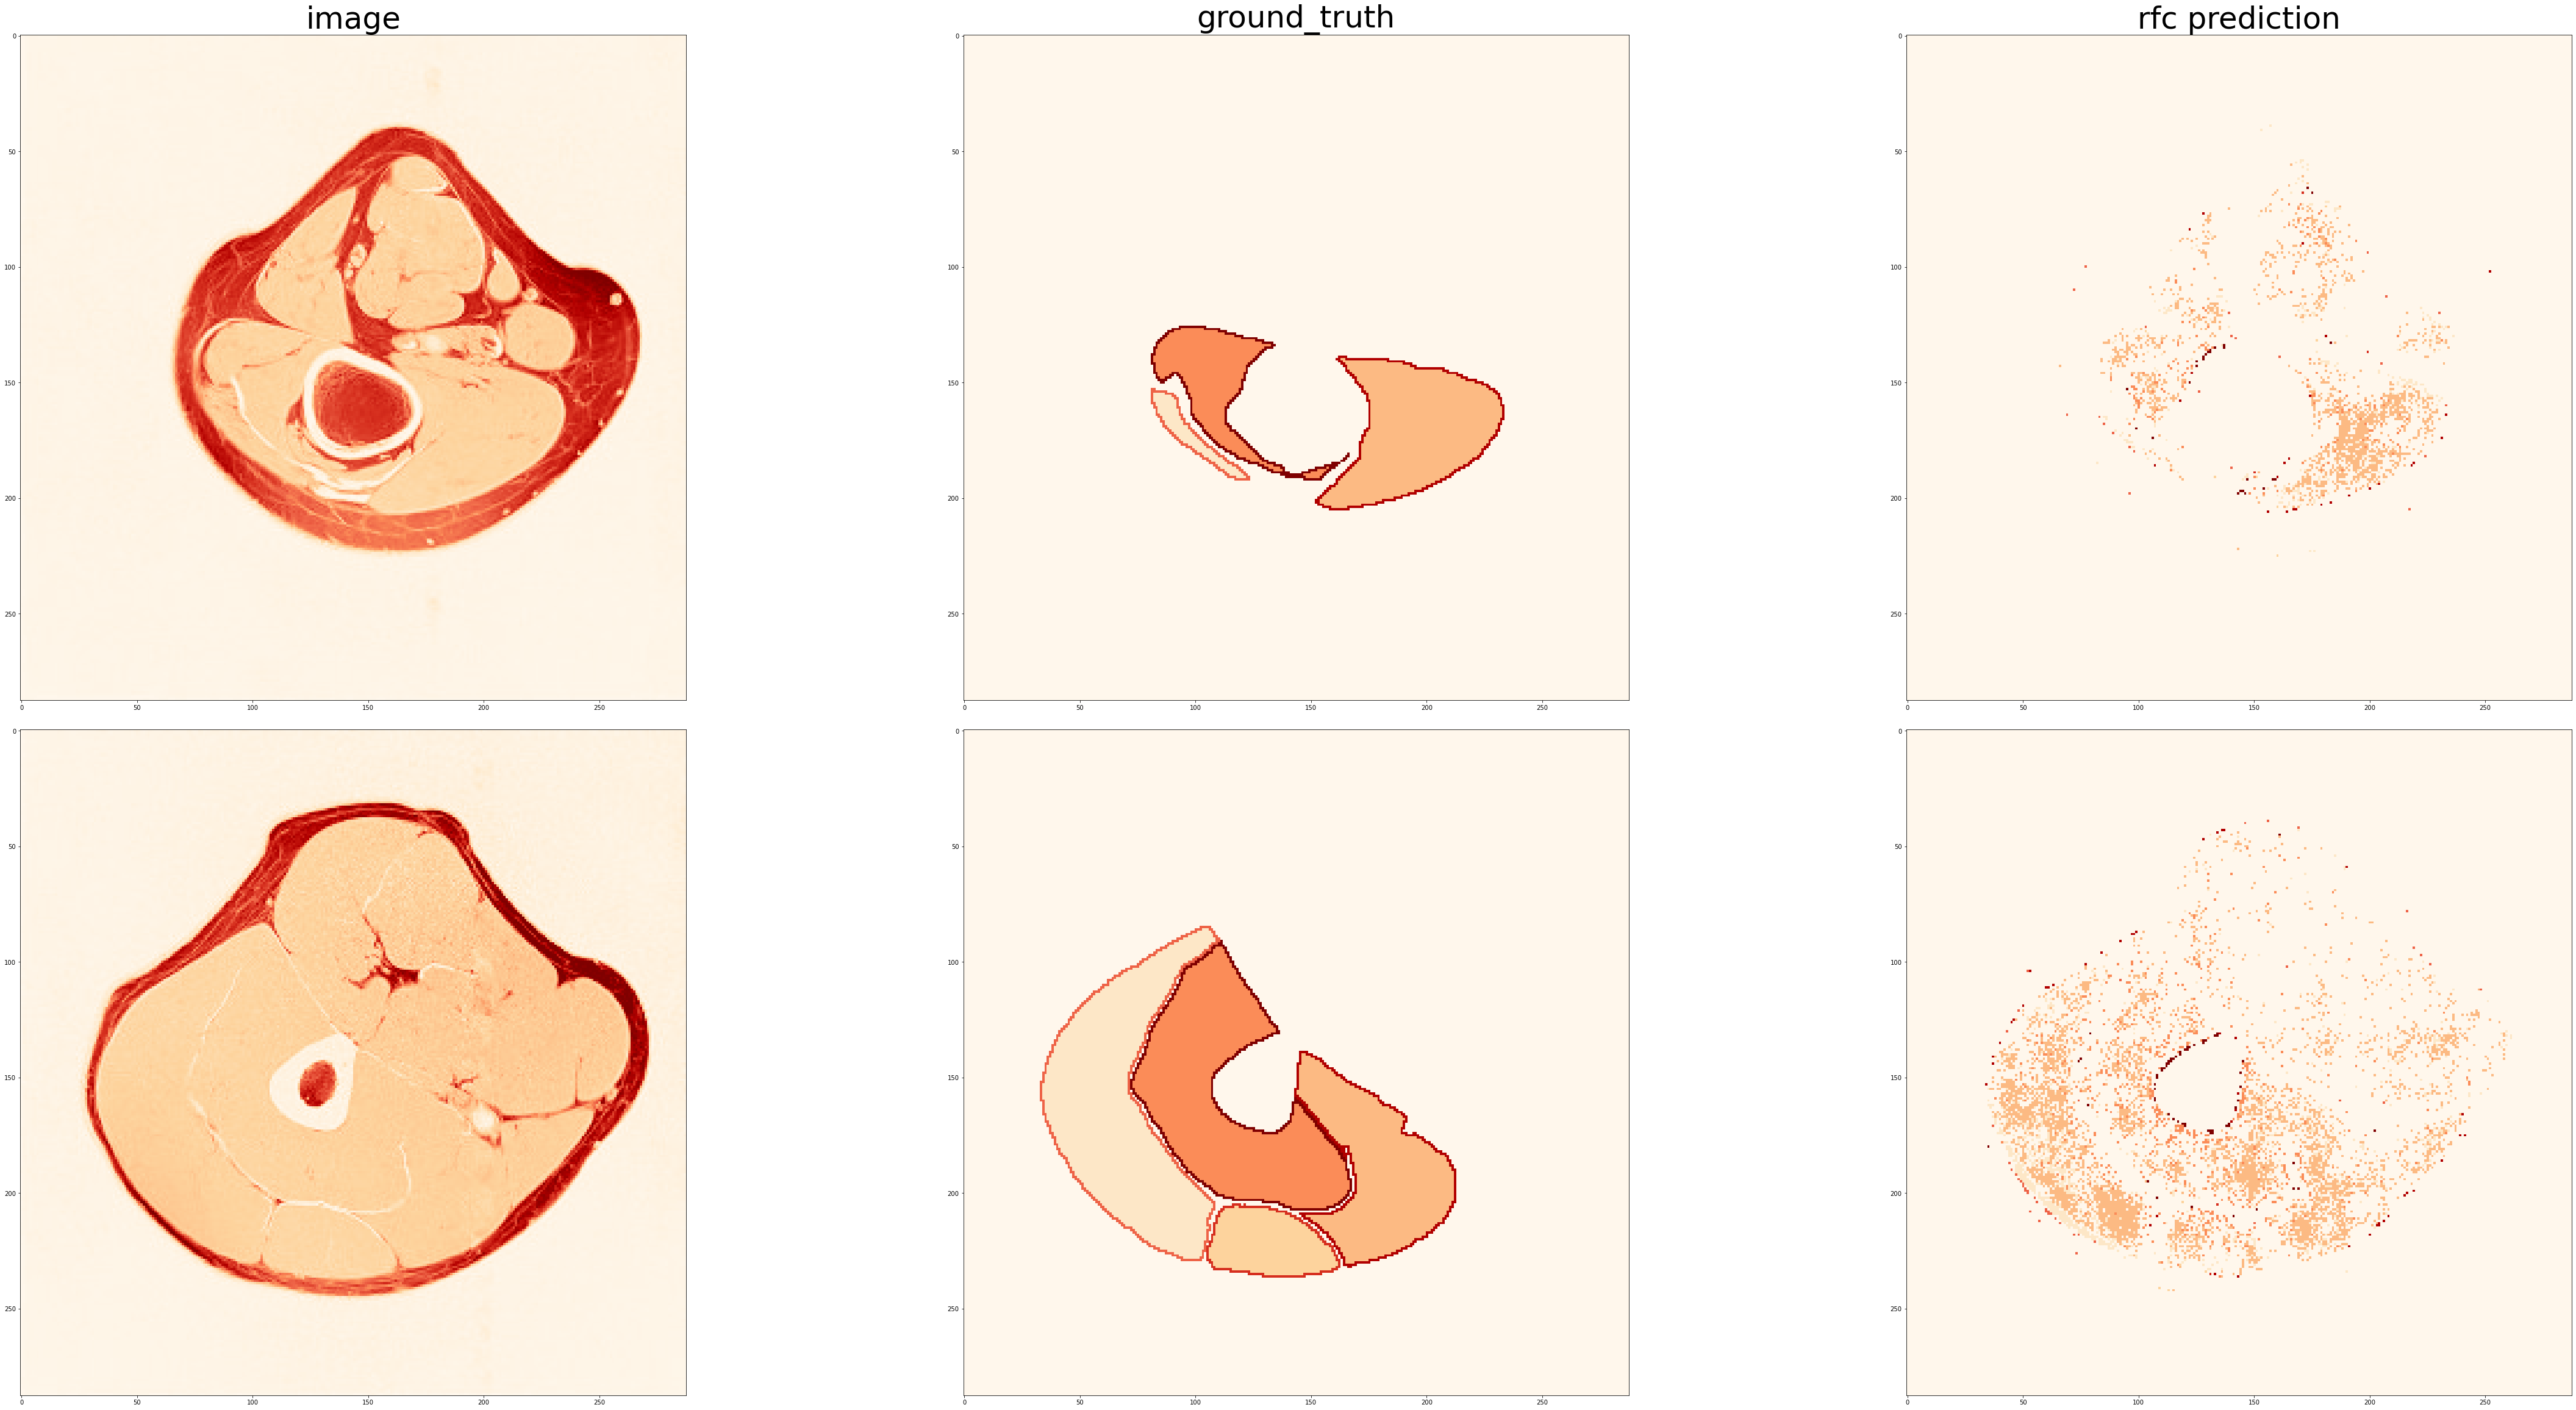

In [52]:
fig, axs = plt.subplots(2, 3, figsize=(64, 32), constrained_layout=True)
FIGURE1 = [Image.open(test_input_img_paths[3]),Image.open(test_target_img_paths[3]),pred_rfc_2nd1]
FIGURE2 = [Image.open(test_input_img_paths[50]), Image.open(test_target_img_paths[50]),pred_rfc_2nd2] 
title = ["image","ground_truth","rfc prediction"]

for i in range(3):
    axs[0,i].imshow(FIGURE1[i],cmap='OrRd')
    axs[0,i].grid(False)
    axs[0,i].set_title(title[i],fontsize = 50)
    axs[1,i].imshow(FIGURE2[i],cmap='OrRd')
    axs[1,i].grid(False)  

In [53]:
## INDICE DE JACCARD POUR LA premire IMAGE
v1,v2 = data_for_jaccard([test_target_img_paths[3]], pred_rfc_2nd1)
jaccard_score(v1,v2 ,average='macro')

0.14176932946323542

In [54]:
## INDICE DE JACCARD POUR LA seconde IMAGE
v1,v2 = data_for_jaccard([test_target_img_paths[50]], pred_rfc_2nd2)
jaccard_score(v1,v2 ,average='macro')

0.14014650677486412

### <font color='darkblue'> Résultat et Conclusion </font>
Dans ce notebook nous avons utilisé 35 images pour l'apprentissage de la tâche de segmentation sématique de coupes transeversales. En utilisant uniquement les intensité des 8 pixels voisins et celui du pixel lui même, on aboutit à des résultats très légèrement meilleurs qu'en utilisant les filtres, quoique dans les deux cas on n'a pas un bon résultat (voir les indices de jaccard). Le KNN (5 voisins) semble donner un meilleur résultat par rapport aux forêts aléatoires (15 arbres) dans le cas où on utilise les intensités des pixels voisins et dans le cas où on utilise des filtres les résultats ne diffèrent pas.

Toutefois tous ces observations sont à prendre avec précaution car les échantillons utilisés sont de taille très réduite et donc ne sont pas généralisables. La durée d'exécution par méthode constitue une limite pour faire une recherche en grille (grid search) des hyperparamètres optimaux. Il faudra également peut être mieux paramétrer les filtres de Gabor par exemple, envisager d'utiliser les réseaux de neurones si on veut traiter plus d'images, quoique avec avec quelques images on commence déjà par avoir un début de résultat.

### <font color='darkblue'>Références </font>

- Jason Adams Yumou Qiu Yuhang Xu, James C. Schnable (2019). Plant segmentation by supervised machine learning methods.  (DOI: 10.1002/ppj2.20001)
    
- Sreeni (2019) : Image Segmentation using traditional machine learning (Part 1,2,3,4,5);  https://www.youtube.com/watch?v=6yW31TT6-wA&t=299s ; https://github.com/bnsreenu/python_for_microscopists
        
- Xuejun Wang, Shuang Wang, Yubin Zhu, Xiangyi Meng (2012). Image Segmentation Based on Support Vector Machine  

- Cheng Chen, John A. Ozolek, Wei Wang, Gustavo K. Rohde (2011). A PIXEL CLASSIFICATION SYSTEM FOR SEGMENTING BIOMEDICAL IMAGES USING INTENSITY NEIGHBORHOODS AND DIMENSION REDUCTION

- ARNAUD CALMETTES, GUILLAUME CEDILLE : VISION PAR ORDINATEUR – FILTRES DE GABOR